In [10]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio

In [11]:
transform  = transforms.Compose([
    transforms.Resize(50),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [12]:
trainData = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testData = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
batch_size = 10
trainLoader = DataLoader(trainData, batch_size)
testLoader = DataLoader(testData, batch_size)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


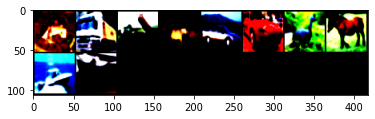

frog  truck truck deer  car   car   bird  horse ship  cat  


In [14]:
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainLoader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [15]:
class ConvNet(nn.Module):
    def __init__(self, init_weights=False):
        super(ConvNet, self).__init__()
        #INITIALIZE LAYERS HERE
        self.network = nn.Sequential(
                nn.Conv2d(3, 16, 3),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.MaxPool2d(2,2),
                nn.BatchNorm2d(16),

                nn.Conv2d(16, 32, 3),
                nn.ReLU(),
                nn.Conv2d(32, 64, 3),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                nn.BatchNorm2d(64),

                nn.Conv2d(64, 128, 3),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                nn.BatchNorm2d(128),


                nn.Flatten(),
                nn.Linear(128*4*4, 512),
                nn.Dropout(0.5),
                nn.ReLU(),
                nn.Linear(512, 10))


        if init_weights:
            self._initialize_weights()

  
    def forward(self, x):
		#PASS IMAGE X THORUGH EACH LAYER DEFINED ABOVE
        out = self.network(x)
        return out

    # def _initialize_weights(self):
    #     #INITIALIZE WEIGHTS

In [16]:
## set device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu") 

model = ConvNet()
model.to(device)

ConvNet(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=2048, out_features=512, bias=T

In [17]:
# optimizer -Adam 
# loss funcion - Cross Entropy
from torchsummary import summary
learningRate = 0.001
optimizer = torch.optim.Adam(model.parameters(), learningRate, weight_decay=0.0005)

noOfEpochs = 4

summary(model, (3,50,50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             448
              ReLU-2           [-1, 16, 48, 48]               0
           Dropout-3           [-1, 16, 48, 48]               0
         MaxPool2d-4           [-1, 16, 24, 24]               0
       BatchNorm2d-5           [-1, 16, 24, 24]              32
            Conv2d-6           [-1, 32, 22, 22]           4,640
              ReLU-7           [-1, 32, 22, 22]               0
            Conv2d-8           [-1, 64, 20, 20]          18,496
              ReLU-9           [-1, 64, 20, 20]               0
        MaxPool2d-10           [-1, 64, 10, 10]               0
      BatchNorm2d-11           [-1, 64, 10, 10]             128
           Conv2d-12            [-1, 128, 8, 8]          73,856
             ReLU-13            [-1, 128, 8, 8]               0
        MaxPool2d-14            [-1, 12

In [18]:
import statistics

plotTrainAccuracy = []
plotTrainLoss = []
plotTestAccuracy = []
test_min_acc = 0
trainLoss = []
trainAccuracy = []
testAccuracy = []

model.train()
for epoch in range(noOfEpochs):
  total = 0
  correct = 0
  running_loss =0

  for i, data in enumerate(trainLoader, 0):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)

    loss = F.cross_entropy(outputs, labels)

    running_loss += loss.item()
    _, preds = torch.max(outputs, dim=1)
    accuracy = torch.tensor(torch.sum(preds == labels).item() / len(preds))

    trainLoss.append(running_loss/100)
    trainAccuracy.append(accuracy)

    loss.backward()
    optimizer.step()

    total += len(preds)
    correct += torch.sum(preds == labels)

    if i % 100 == 99:    # print every 100 mini-batches
            print('Train: [%d, %5d] loss: %.3f acc: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100,100.0*correct/total))
            running_loss = 0.0
    
  # TESTING
  # testing the learnt model on test set

  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
    for data in testLoader:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      testOutputs = model(inputs)

      loss = F.cross_entropy(testOutputs, labels)

      # running_loss += loss.item()

      _, preds = torch.max(testOutputs, dim=1)
      accuracy = torch.tensor(torch.sum(preds == labels).item() / len(preds))

      testAccuracy.append(accuracy)
  test_ep_acc = testAccuracy[-1]
  print('Test Accuracy: %.3f %%' % (test_ep_acc))

  # Saving the best model
  if test_min_acc < test_ep_acc:
      test_min_acc = test_ep_acc
      torch.save(model, 'my_best_model.pth')

  np.savetxt('data1.csv', np.array(trainAccuracy)[5000*epoch:5000*(epoch+1)-1], delimiter=',', fmt='%f')
  plotTrainAccuracy.append(statistics.mean(np.array(trainAccuracy)[5000*epoch:5000*(epoch+1)-1]))

  np.savetxt('data2.csv', np.array(trainLoss)[5000*epoch:5000*(epoch+1)-1], delimiter=',', fmt='%f')
  plotTrainLoss.append(statistics.mean(np.array(trainLoss)[5000*epoch:5000*(epoch+1)-1]))

  np.savetxt('data3.csv', np.array(testAccuracy)[5000*epoch:5000*(epoch+1)-1], delimiter=',',fmt='%f')
  plotTestAccuracy.append(statistics.mean(np.array(testAccuracy)[1000*epoch:1000*(epoch+1)-1]))

np.save('test_accuracy.npy',testAccuracy); sio.savemat('test_accuracy.mat', mdict={'test_accuracy': testAccuracy})
np.save('train_accuracy.npy',trainAccuracy); sio.savemat('train_accuracy.mat', mdict={'train_accuracy': trainAccuracy})
np.save('train_loss.npy',trainLoss); sio.savemat('train_loss.mat', mdict={'train_loss': trainLoss})

Train: [1,   100] loss: 2.241 acc: 26.500
Train: [1,   200] loss: 2.125 acc: 28.550
Train: [1,   300] loss: 1.963 acc: 30.300
Train: [1,   400] loss: 1.867 acc: 31.600
Train: [1,   500] loss: 1.776 acc: 33.280
Train: [1,   600] loss: 1.726 acc: 34.433
Train: [1,   700] loss: 1.649 acc: 35.671
Train: [1,   800] loss: 1.613 acc: 36.662
Train: [1,   900] loss: 1.529 acc: 37.656
Train: [1,  1000] loss: 1.519 acc: 38.580
Train: [1,  1100] loss: 1.535 acc: 39.318
Train: [1,  1200] loss: 1.445 acc: 40.242
Train: [1,  1300] loss: 1.491 acc: 40.831
Train: [1,  1400] loss: 1.483 acc: 41.436
Train: [1,  1500] loss: 1.379 acc: 42.047
Train: [1,  1600] loss: 1.443 acc: 42.675
Train: [1,  1700] loss: 1.387 acc: 43.206
Train: [1,  1800] loss: 1.355 acc: 43.789
Train: [1,  1900] loss: 1.312 acc: 44.305
Train: [1,  2000] loss: 1.354 acc: 44.640
Train: [1,  2100] loss: 1.338 acc: 45.071
Train: [1,  2200] loss: 1.347 acc: 45.441
Train: [1,  2300] loss: 1.347 acc: 45.687
Train: [1,  2400] loss: 1.200 acc:

In [19]:
# testing the learnt model on test set
# testAccuracy = []
# correct = 0
# total = 0
# model.eval()
# with torch.no_grad():
#   for data in testLoader:
#     inputs, labels = data
#     inputs = inputs.to(device)
#     labels = labels.to(device)

#     testOutputs = model(inputs)

#     loss = F.cross_entropy(testOutputs, labels)

#     # running_loss += loss.item()

#     _, preds = torch.max(testOutputs, dim=1)
#     accuracy = torch.tensor(torch.sum(preds == labels).item() / len(preds))

#     testAccuracy.append(accuracy)

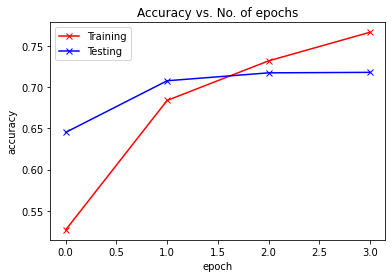

In [20]:
plt.plot(plotTrainAccuracy, '-rx')
plt.plot(plotTestAccuracy, '-bx')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Training', 'Testing'])
plt.title('Accuracy vs. No. of epochs');

In [21]:
plotTrainAccuracy

[0.52672535, 0.6839168, 0.7319664, 0.7667133]

In [22]:
plotTrainLoss

[0.6937366294431601,
 0.45546944399775086,
 0.38468816222977337,
 0.33457068753319397]

In [23]:
plotTestAccuracy

[0.6451452, 0.70780784, 0.7174174, 0.718018]

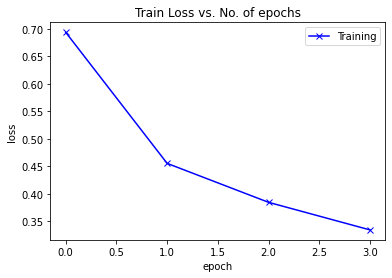

In [24]:
plt.plot(plotTrainLoss, '-bx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training'])
plt.title('Train Loss vs. No. of epochs');

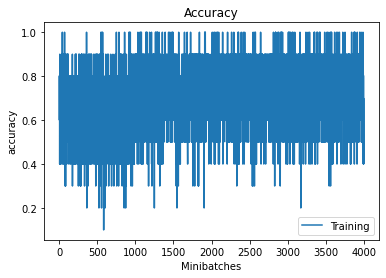

In [25]:
# plt.plot(trainAccuracy, '-rx')
plt.plot(testAccuracy)
plt.xlabel('Minibatches')
plt.ylabel('accuracy')
plt.legend(['Training', 'Testing'])
plt.title('Accuracy');